In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))


In [3]:
dataset=(transactions
 .merge(items.drop(columns="item_name"),how="left")
 .assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+2013).astype(int))
 .drop(columns="date")

)

In [493]:
dataset

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year
0,0,59,22154,999.000,1.000,37,1,2013
1,0,25,2552,899.000,1.000,58,1,2013
2,0,25,2552,899.000,-1.000,58,1,2013
3,0,25,2554,1709.050,1.000,58,1,2013
4,0,25,2555,1099.000,1.000,56,1,2013
5,0,25,2564,349.000,1.000,59,1,2013
6,0,25,2565,549.000,1.000,56,1,2013
7,0,25,2572,239.000,1.000,55,1,2013
8,0,25,2572,299.000,1.000,55,1,2013
9,0,25,2573,299.000,3.000,55,1,2013


Items can be mean-encoded by taking their mean and std, some products are highly variable. And then, within each shop, we will also include the same features

In [4]:
aggregated_data=(dataset
                 
.drop(columns=["year","item_price","month","item_category_id"])
 
.groupby(["date_block_num","shop_id","item_id"]).sum()
 .reset_index()
 .assign(item_cnt_day=lambda x: np.clip(x.item_cnt_day,0,20))
)

In [10]:
singles=aggregated_data[["date_block_num","item_id"]].groupby(["date_block_num","item_id"]).count().reset_index()

In [18]:
singles

,date_block_num,item_id
0,0,19
1,0,27
2,0,28
3,0,29
4,0,32
5,0,33
6,0,34
7,0,35
8,0,40
9,0,41


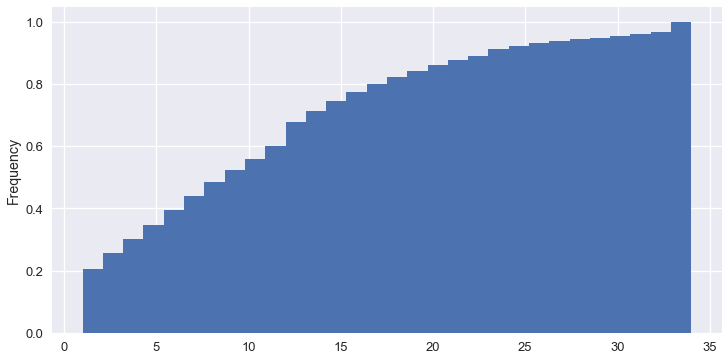

In [31]:
#Some items are always there. Others are very rare
singles.item_id.value_counts().plot.hist(bins=30,cumulative=True,density=1)

0.8664326621097358

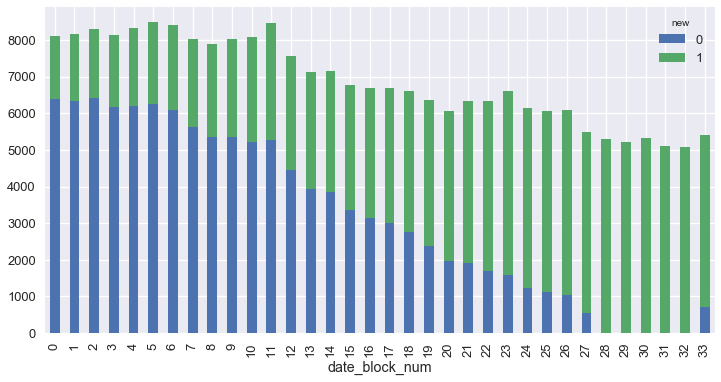

In [142]:
#Out of all the items, which ones appear in later months
singles=aggregated_data[["date_block_num","item_id"]].groupby(["date_block_num","item_id"]).count().reset_index()
l=singles.query("date_block_num in [32,31,30,29,28]").item_id.unique()
new_items=[item for item in singles.item_id.unique() if item  in l]

def plotter(x):
    x.plot.bar(stacked=True)
    return x
(singles
.assign(new=lambda x: np.where(x.item_id.isin(new_items),1,0))
 .groupby(["date_block_num","new"])
          .count()
 .unstack()
 .item_id
 .pipe(plotter)
 .pipe(lambda x: x.iloc[-1])
 .pipe(lambda x: x/x.sum())
 .iloc[1]
 
)


In [109]:
goback_orig = range(10,15)
res=[]
def trier(x):
    try:
        return x.iloc[1]
    except:
        return 0
for i in goback_orig:
    goback = range(i)
    ran = [(32 - i) for i in goback]
    print(ran)
    l = singles.query("date_block_num in @ran").item_id.unique()
    new_items = [item for item in singles.item_id.unique() if item in l]
    res.append(singles
     .assign(new=lambda x: np.where(x.item_id.isin(new_items), 1, 0))
     .groupby(["date_block_num", "new"])
     .count()
     .unstack()
     .item_id
     .pipe(lambda x: x.iloc[-1])
     .pipe(lambda x: x / x.sum())
     .pipe(trier)
     )

[32, 31, 30, 29, 28, 27, 26, 25, 24, 23]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19]


In [267]:
ran = [(33 - i) for i in range(6)]
singles=aggregated_data[["date_block_num","item_id"]].groupby(["date_block_num","item_id"]).count().reset_index()
items_kept= singles.query("date_block_num in @ran").item_id.unique()

In [268]:
ran

[33, 32, 31, 30, 29, 28]

In [162]:
pd.Series(items_kept).to_csv("items_kept.csv",index=False)

1.0

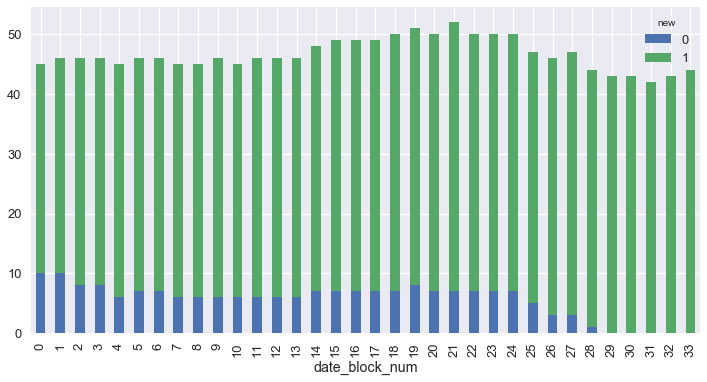

In [200]:

singles=aggregated_data[["date_block_num","shop_id"]].groupby(["date_block_num","shop_id"]).count().reset_index()

l=singles.query("date_block_num in [33,32,31,30]").shop_id.unique()
new_items=[item for item in singles.shop_id.unique() if item  in l]


def plotter(x):
    x.plot.bar(stacked=True)
    return x
(singles
.assign(new=lambda x: np.where(x.shop_id.isin(new_items),1,0))
 .groupby(["date_block_num","new"])  .count()
 .unstack()
 .shop_id
 .pipe(plotter)
 .pipe(lambda x: x.iloc[-1])
 .pipe(lambda x: x/x.sum())
 .iloc[1]
 
)

In [193]:
ran = [(33 - i) for i in range(13)]
singles=aggregated_data[["date_block_num","shop_id"]].groupby(["date_block_num","shop_id"]).count().reset_index()
shops_kept= singles.query("date_block_num in @ran").shop_id.unique()

In [159]:
pd.Series(shops_kept).to_csv("shops_kept.csv",index=False)

# What is new in test

In [165]:
#All shops in test are in train
set(test.shop_id.unique())-set(shops_kept)

set()

In [198]:
#These shops in train do not appear in test
set(shops_kept)-set(test.shop_id.unique())

{9, 11, 17, 20, 27, 29, 30, 33, 40, 43, 51, 54}

In [216]:
#These items are new, or old

new_items=set(test.item_id.unique())-set(items_kept)
new_items
len(new_items)

447

In [208]:
#We cannot just say that items above X are new
test.item_id.max()
transactions.item_id.max()

22169

In [215]:
#These items are literally new, we have no record of them
real_new_items=set(test.item_id.unique())-set(transactions.item_id.unique())
len(real_new_items)

363

In [214]:
#So these items are old
set(test.item_id.unique())

4737

In [217]:
len(test.item_id.unique())

5100

In [275]:
#Fake combinations
test_combis=test.shop_id.astype(str)+"-"+test.item_id.astype(str)

In [468]:
t=aggregated_data.query("date_block_num>=20")
existing_combis=t.shop_id.astype(str)+"-"+t.item_id.astype(str)

In [469]:
fake_combis=set(test_combis)-set(existing_combis)

In [459]:
past_month=(aggregated_data.query("date_block_num in [33]")
.groupby(["item_id","shop_id"]).median().reset_index()
[["shop_id","item_id","item_cnt_day"]])

past_month2=(aggregated_data.query("date_block_num in [33-12]")
.groupby(["item_id","shop_id"]).mean().reset_index()
[["shop_id","item_id","item_cnt_day"]]).rename(columns={"item_cnt_day":"item_cnt_old"})
a=past_month.shop_id.unique()
b=past_month.item_id.unique()
mg=np.meshgrid(a,b)
past_month=pd.DataFrame({"shop_id":mg[0].ravel(),"item_id":mg[1].ravel()}).merge(past_month,how="left").fillna(0)

In [374]:
#Shop by size
categoryvalues=(aggregated_data.query("date_block_num in [33,32]")
 .merge(items.drop(columns="item_name"),how="left")
 .groupby(["item_category_id","shop_id"])
 .item_cnt_day
 .mean()
 .reset_index()
.rename(columns={"item_cnt_day":"item_cnt_cat"})                

 
)
categoryvalues

,item_category_id,shop_id,item_cnt_cat
0,2,3,1.000
1,2,4,1.400
2,2,5,1.667
3,2,6,1.000
4,2,7,1.167
5,2,12,1.143
6,2,15,1.000
7,2,16,2.000
8,2,18,1.000
9,2,19,1.000


In [20]:
t=(test
   #.assign(new=lambda x: x.item_id.isin(items_kept))
 .merge(items.drop(columns="item_name"), how="left")
 #.merge(categoryvalues, how="left")
 .merge(past_month.query("date_block_num==33"), how="left")
#.merge(past_month2, how="left")
# .assign(item_cnt_day=lambda x: np.where(x.new, x.item_cnt_day, 0))
 #.assign(combi=lambda x: x.shop_id.astype(str) + "-" + x.item_id.astype(str))
 #.assign(fake_combi=lambda x: x.combi.isin(fake_combis))
 #.assign(item_cnt_day=lambda x: np.where(x.eval("fake_combi and item_id not in @real_new_items"), 0, x.item_cnt_day))
 #.assign(newprod=lambda x: np.where(x.item_id.isin(real_new_items), True, False))

# .assign(item_cnt_day=lambda x: np.where(x.item_cnt_day.isnull(), x.item_cnt_old, x.item_cnt_day))
 #.assign(item_cnt_day=lambda x: np.where(x.newprod, np.nan, x.item_cnt_day))
 
# .assign(item_cnt_day=lambda x: np.where(x.item_cnt_day.isnull(), x.item_cnt_cat, x.item_cnt_day))
#.fillna(0)
#[["ID","item_cnt_day"]]
 .rename(columns={"item_cnt_day": "item_cnt_month"})
 #.item_cnt_month.value_counts(dropna=False)
 )
#.to_csv("simplest_model_ever_lol.csv.gz",compression="gzip",index=False)

In [22]:
t.item_cnt_month.value_counts(dropna=False)

0.000     169572
1.000      19264
nan        16002
2.000       4829
3.000       1806
4.000        880
5.000        505
6.000        311
7.000        199
20.000       197
8.000        136
9.000        115
10.000        74
11.000        56
12.000        52
13.000        47
14.000        40
15.000        35
16.000        28
18.000        21
17.000        19
19.000        12
Name: item_cnt_month, dtype: int64

In [426]:
t

,ID,shop_id,item_id,new,item_category_id,item_cnt_cat,item_cnt_month,item_cnt_old,combi,fake_combi,newprod
0,0,5,5037,True,19,1.989,1.989,0.000,5-5037,False,False
1,1,5,5320,False,55,1.159,1.159,0.000,5-5320,True,True
2,2,5,5233,True,19,1.989,1.000,0.000,5-5233,False,False
3,3,5,5232,True,23,1.616,1.616,0.000,5-5232,False,False
4,4,5,5268,False,20,2.889,2.889,0.000,5-5268,True,True
5,5,5,5039,True,23,1.616,1.000,0.000,5-5039,False,False
6,6,5,5041,True,20,2.889,2.000,0.000,5-5041,False,False
7,7,5,5046,True,55,1.159,1.159,0.000,5-5046,False,False
8,8,5,5319,True,55,1.159,1.159,0.000,5-5319,False,False
9,9,5,5003,True,20,2.889,0.000,0.000,5-5003,True,False


In [434]:
t.corr()

,ID,shop_id,item_id,new,item_category_id,item_cnt_cat,item_cnt_month,item_cnt_old,fake_combi,newprod
ID,1.000,0.771,0.002,-0.002,0.004,-0.103,-0.077,-0.039,0.076,-0.000
shop_id,0.771,1.000,-0.000,0.000,-0.000,-0.041,-0.003,0.004,-0.004,0.000
item_id,0.002,-0.000,1.000,0.025,0.268,-0.021,-0.069,-0.048,0.045,-0.035
new,-0.002,0.000,0.025,1.000,0.004,0.032,-0.035,0.063,-0.254,-0.797
item_category_id,0.004,-0.000,0.268,0.004,1.000,-0.204,-0.159,-0.079,0.144,0.003
item_cnt_cat,-0.103,-0.041,-0.021,0.032,-0.204,1.000,0.534,0.310,-0.361,-0.006
item_cnt_month,-0.077,-0.003,-0.069,-0.035,-0.159,0.534,1.000,0.417,-0.567,0.115
item_cnt_old,-0.039,0.004,-0.048,0.063,-0.079,0.310,0.417,1.000,-0.191,-0.052
fake_combi,0.076,-0.004,0.045,-0.254,0.144,-0.361,-0.567,-0.191,1.000,0.202
newprod,-0.000,0.000,-0.035,-0.797,0.003,-0.006,0.115,-0.052,0.202,1.000


# Lesson: Do backfilling !!
What can we "know" for sure:

In [6]:
l=aggregated_data.query("date_block_num>12")
a=l.shop_id.unique()
b=l.item_id.unique()
mg=np.meshgrid(a,b)

In [7]:
past_month=pd.concat([pd.DataFrame({"shop_id":mg[0].ravel(),"item_id":mg[1].ravel(),"date_block_num":i}) for i in range(12,34)])

past_month=past_month.merge(l,how="left")
past_month["item_cnt_day"].fillna(0,inplace=True)

In [14]:
past_month

,date_block_num,item_id,shop_id,item_cnt_day
0,12,472,2,0.000
1,12,472,3,0.000
2,12,472,4,0.000
3,12,472,5,0.000
4,12,472,6,0.000
5,12,472,7,0.000
6,12,472,10,0.000
7,12,472,12,0.000
8,12,472,13,0.000
9,12,472,14,0.000
